In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using Plots
using LadderDGA
using Logging

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

# Setup and read DMFT quantities

In [2]:
cfg_file = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0/config_j.toml";
cfg_file2 = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s1_b12_u1.0/config_j.toml";

mP, sP, env, kGrids, qGridLoc, freqList = readConfig(cfg_file)
kG = kGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp, GLoc, GLoc_fft, Σ_loc, FUpDo  = setup_LDGA(kG, freqList, mP, sP, env);

mP2, sP2, env2, kGrids2, qGridLoc2, freqList2 = readConfig(cfg_file2)
kG2 = kGrids2[1]
νGrid2, sumHelper_f2, impQ_sp2, impQ_ch2, GImp2, GLoc2, GLoc_fft2, Σ_loc2, FUpDo2 = setup_LDGA(kG2, freqList2, mP2, sP2, env2);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 12:30 and 12:30 to the same range of 12:30
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(12:30) = 0.1873, χLoc_ch(12:30) = 0.117 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.15212618731682778 ?≈? 0.15212618731682775 ?=? 0.15212618731682775 ?≈? 0.25"
[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 12:30 and 12:30 to the same range of 12:30
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(12:30) = 0.1882, χLoc_ch(12:30) = 0.1179 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.15306538150223747 ?≈? 0.1530653815022375 ?=? 0.1530653815022375 ?≈? 0.25"


In [3]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

# ladder quantities
bubble = calc_bubble(νGrid, GLoc_fft, kG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, kG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, kG, νGrid, sumHelper_f, -mP.U, mP, sP);
nlQ_sp_nλ = deepcopy(nlQ_sp)
nlQ_ch_nλ = deepcopy(nlQ_ch)

λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, kG, mP, sP)

Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];

[ Warning: TODO: inefficient EoM calculation (throwing away 1/2 of array)
┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(13:29,13:29) = 13:29 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 13:29, length: 17
│ ch: 13:29, length: 17
│ usable: 13:29, length: 17
└ χch sum = 0.11236015085692581, rhs = 0.19189222377672976
┌ Info: found 
│   χ_min = -0.24463037517440542
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.24463037517440542, 4.892607503488108]"
┌ Info: Found λsp 
└   λsp = 0.38117985584899217
[ Info: new lambda correction: λsp=0.0 and λch=0.0
[ Warning: TODO: inefficient EoM calculation (throwing away 1/2 of array)


In [4]:
# "local" correction quantities
bubbleLoc2 = calc_bubble(νGrid2, GImp, qGridLoc2, mP2, sP2);
locQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubbleLoc2, qGridLoc2, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
locQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubbleLoc2, qGridLoc2, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);
Σ_ladderLoc2 = calc_Σ(locQ_sp2, locQ_ch2, bubbleLoc2, GImp, FUpDo2,
                     qGridLoc2, sumHelper_f2, mP2, sP2)
Σ_ladderLoc2 = Σ_ladderLoc2 .+ mP2.n * mP2.U/2.0;

# ladder quantities
bubble2 = calc_bubble(νGrid2, GLoc_fft2, kG2, mP2, sP2);
nlQ_sp2 = calc_χ_trilex(impQ_sp2.Γ, bubble2, kG2, νGrid2, sumHelper_f2, mP2.U, mP2, sP2);
nlQ_ch2 = calc_χ_trilex(impQ_ch2.Γ, bubble2, kG2, νGrid2, sumHelper_f2, -mP2.U, mP2, sP2);
nlQ_sp_nλ2 = deepcopy(nlQ_sp2)
nlQ_ch_nλ2 = deepcopy(nlQ_ch2)

λ_sp2, λ_spch2  = λ_correction!(impQ_sp2, impQ_ch2, FUpDo2, Σ_loc2, Σ_ladderLoc2, nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, kG2, mP2, sP2)

Σ_ladder2 = calc_Σ(nlQ_sp2, nlQ_ch2, bubble2, GLoc_fft2, FUpDo2, kG2, sumHelper_f2, mP2, sP2)
Σ_ladder_corrected2 = Σ_ladder2 .- Σ_ladderLoc2 .+ Σ_loc2[1:size(Σ_ladder2,1)];

[ Warning: TODO: inefficient EoM calculation (throwing away 1/2 of array)
┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(13:29,13:29) = 13:29 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 13:29, length: 17
│ ch: 13:29, length: 17
│ usable: 13:29, length: 17
└ χch sum = 0.11300729049627967, rhs = 0.19312347250819528
┌ Info: found 
│   χ_min = -0.24463037517512026
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [-0.24463037517512026, 4.892607503502405]"
┌ Info: Found λsp 
└   λsp = 0.37575917603223175
[ Info: new lambda correction: λsp=0.0 and λch=0.0
[ Warning: TODO: inefficient EoM calculation (throwing away 1/2 of array)


In [5]:
iνₙ = LadderDGA.iν_array(mP.β, 0:(sP.n_iν-1))
iνₙ, GImp    = LadderDGA.readGImp(env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:20], ϵₖ, Vₖ, GImp[1:20], mP)
E_kin_ED_large, E_pot_ED_large  = LadderDGA.calc_E_ED(iνₙ[1:5000], ϵₖ, Vₖ, GImp[1:5000], mP)

(-0.7618733847649715, 0.2035812924974587)

In [6]:
ep_loc, ek_loc = LadderDGA.calc_E(Σ_loc[1:sP.n_iν], kG, mP, sP);

In [7]:
usable_ω = intersect(impQ_sp.usable_ω, impQ_ch.usable_ω);

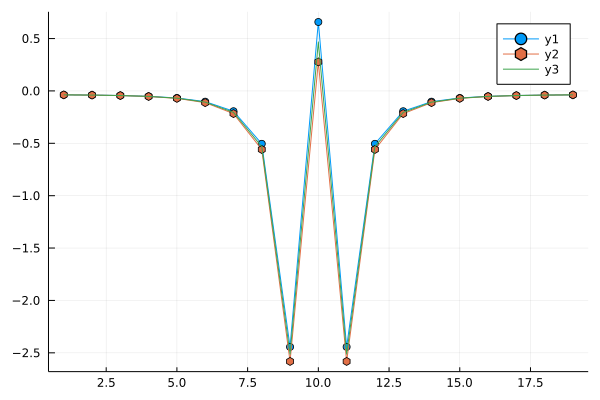

In [8]:
subtract_tail = LadderDGA.subtract_tail
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[usable_ω] .* π ./ mP.β
plot(real(subtract_tail(impQ_sp.χ_ω[usable_ω], E_kin_ED_large,iωn)), markershape=:circle)
plot!(real(subtract_tail(impQ_ch.χ_ω[usable_ω], E_kin_ED_large, iωn )), markershape=:hexagon)
plot!(real(subtract_tail(0.5*(impQ_sp.χ_ω .+ impQ_ch.χ_ω )[usable_ω], E_kin_ED_large, iωn)))

In [9]:
function Base.show(io::IO, m::SimulationParameters)
    compact = get(io, :compact, false)
    if !compact
        println(io, "B/F range    : $(m.n_iω)/$(m.n_iν) $(m.shift ? "with" : "without") shifted fermionic frequencies")
        println(io, "   ωsum type = $(m.ωsum_type) $(m.fullChi ? "with" : "without") full χ(ω) range computation (filled as $(m.χFillType), $(m.dbg_full_eom_omega ? "with" : "without") full ω range in EoM.")
        println(io, "B/F sum type : $(m.tc_type_b)/$(m.tc_type_f)")
        println(io, "   $(100*m.usable_prct_reduction) % reduction of usable range and ω smoothing $(m.usable_prct_reduction)")
        println(io, "λ-Correction : $(m.λc_type) with rhs $(m.λ_rhs)")
    else
        print(io, "SimulationParams[nB=$m.n_iω, nF=m.n_iν, shift=m.shift]")
    end
    #show(io, sP)
end

function Base.show(io::IO, ::MIME"text/plain", m::SimulationParameters)
 
    println(io, "LadderDGA.jl SimulationParameters:")
    show(io, m)
end

function Base.show(io::IO, m::ModelParameters)
    compact = get(io, :compact, false)

    if !compact
        println(io, "ModelParameters[U=$m.U, μ=$m.μ, β=$m.β, n=$m.n]")
    else
        println(io, "ModelParameters[U=$m.U, μ=$m.μ, β=$m.β, n=$m.n]")
    end
    #show(io, sP)
end

function Base.show(io::IO, ::MIME"text/plain", m::ModelParameters)
 
    println(io, "LadderDGA.jl ModelParameters:")
    #show(io, m)
end

#mP

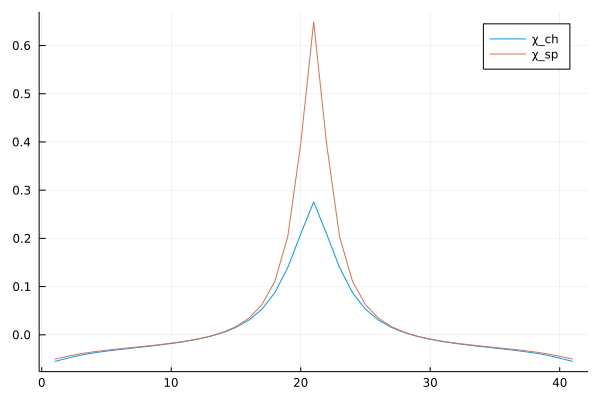

In [10]:
χch_ω = LadderDGA.kintegrate(kG,nlQ_ch.χ, dim=2)[:,1]
χsp_ω = LadderDGA.kintegrate(kG,nlQ_sp.χ, dim=2)[:,1]
plot(real.(χch_ω), label="χ_ch")
plot!(real.(χsp_ω), label="χ_sp")

In [11]:
plot(imag(Σ_loc), markershape=:circle, label="Σ_loc", markersize=6, alpha=0.7, legend=:bottomright)
plot!(imag(Σ_ladderLoc), markershape=:circle, markersize=3,  label="Σ_ladder_loc")
plot!(imag(kintegrate(kG, Σ_ladder_corrected, dim=2)[:,1]), markershape=:circle, label="Σ_k Σ_ladder")

LoadError: UndefVarError: kintegrate not defined

In [12]:
Σ = Σ_ladder_corrected
iν_array = LadderDGA.iν_array
G_from_Σ = LadderDGA.G_from_Σ
flatten_2D = LadderDGA.flatten_2D
kintegrate = LadderDGA.kintegrate
kGrid = kG
# = LadderDGA.

νmax = size(Σ,1)
νGrid = 0:(νmax-1)
iν_n = iν_array(mP.β, νGrid)
Σ_hartree = mP.n * mP.U/2
Σ_corr = Σ .+ Σ_hartree

E_kin_tail_c = [zeros(size(kGrid.ϵkGrid)), (kGrid.ϵkGrid .+ Σ_hartree .- mP.μ)]
E_pot_tail_c = [zeros(size(kGrid.ϵkGrid)),
                (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kGrid.ϵkGrid .+ Σ_hartree .- mP.μ))]
tail = [1 ./ (iν_n .^ n) for n in 1:length(E_kin_tail_c)]
E_pot_tail = sum(E_pot_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_kin_tail = sum(E_kin_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kGrid.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c[2]])
E_kin_tail_inv = sum(map(x->x .* (mP.β/2) .* kGrid.ϵkGrid , [1, -(mP.β) .* E_kin_tail_c[2]]))

G_corr = flatten_2D(G_from_Σ(Σ_corr, kGrid.ϵkGrid, νGrid, mP));
E_pot = real.(G_corr .* Σ_corr .- E_pot_tail);
E_kin = kGrid.ϵkGrid' .* real.(G_corr .- E_kin_tail);

E_pot = [kintegrate(kGrid, 2 .* sum(E_pot[1:i,:], dims=[1])[1,:] .+ E_pot_tail_inv) for i in 1:νmax]
E_kin = [kintegrate(kGrid, 4 .* sum(E_kin[1:i,:], dims=[1])[1,:] .+ E_kin_tail_inv) for i in 1:νmax];